**Preprocesamiento de la base de datos de Walmart**

Este archivo consta de los codigos y conclusiones de:
* 1.Separar en datos de entrenamiento y de prueba.
* 2.Implementacion de modelos lineales arima y sarima.


# Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [1]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

#Modulos para trabajar con Arima y Sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split


In [2]:
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install pmdarima --quiet
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00


In [4]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


MessageError: ignored

In [ ]:
cd /content/gdrive/MyDrive/Tesis/Datos

In [ ]:
df=pd.read_csv('df.csv')

In [ ]:
df.set_index('Date', inplace=True)
features = [feature for feature in df.columns if feature not in ('Day','Month','Year','Week')]
df=df[features]


In [ ]:
# create dummy variables
df=pd.get_dummies(df)

In [ ]:
df.shape

In [ ]:
df.head(4)

# Obtener series de Tiempo

*Se obtiene lista de dataframe ordenados por Store y Dept*

In [ ]:
series_time=[]
lista_Store=df.Store.unique()
lista_Store.sort()
lista_dept=df.Dept.unique()
lista_dept.sort()

for i in lista_Store:
  for j in lista_dept:
    test=df[(df.Store==i) & (df.Dept==j)]
    if(test.empty!=True):
        series_time.append(test)

In [ ]:
series_time[0].Weekly_Sales.plot(figsize=(10, 5))


In [ ]:
result=seasonal_decompose(series_time[0]['Weekly_Sales'], model='multiplicable', period=12)

In [ ]:
result.seasonal.plot(figsize=(10, 5))

In [ ]:
result.trend.plot(figsize=(10, 5))

In [ ]:
result.resid.plot(figsize=(10, 5))

#2.Separar en conjunto de entrenamiento y de test

*Se divide en train y test, por cada muestra de serie de tiempo (2660)*

In [ ]:
# Porcentaje de train.
p_train = 0.70

largo_data=series_time[0].shape[0]
train=[]
test=[]
scaled_train=[]
scaled_test=[]

for serie in series_time:
  #Separacion lineal del dataset
  train_data=serie.iloc[0:int(largo_data*p_train),:]
  test_data=serie.iloc[int(largo_data*p_train):largo_data,:]
  #Se guarda el conjunto en las listas:
  train.append(train_data)
  test.append(test_data)
  scaled_train.append(train_data)
  scaled_test.append(test_data)

In [ ]:
train[0].tail()

#Modelos lineales para una serie

##Arima

In [ ]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type_A', 'Type_B',
       'Type_C'],
      dtype='object')

In [ ]:
target="Weekly_Sales"

Modelo ARIMA para pronósticos de series temporales ARIMA significa modelo de promedio móvil integrado autorregresivo y se especifica mediante tres
parámetros de orden: (p, d, q).

* **AR( p ) Autorregresión** : un modelo de regresión que utiliza la relación dependiente entre una observación actual y las observaciones durante un período anterior. Un componente autorregresivo ( AR(p) ) se refiere al uso de valores pasados ​en la ecuación de regresión para la serie temporal .

* **I( d ) Integración** : utiliza la diferenciación de observaciones (restando una observación de la observación en el paso de tiempo anterior) para hacer que la serie de tiempo sea estacionaria. La diferenciación implica la resta de los valores actuales de una serie con sus valores anteriores d número de veces.

* **MA( q ) Promedio móvil** : un modelo que utiliza la dependencia entre una observación y un error residual de un modelo de promedio móvil aplicado a observaciones retrasadas. Un componente de promedio móvil representa el error del modelo como una combinación de términos de error anteriores. El orden q representa el número de términos a incluir en el modelo.

Del modelo:
* Se entrena modelo Auto_Arima para encontrar los mejores coeficientes del modelo.
* Se entrena con 43 pasos hacia delante
* Se obtiene precision del modelo con metricas MAPE y RMSE


In [ ]:
def Auto_Arima(data,trace_value):
  ARIMA_model = pm.auto_arima(data,
                        test='adf',
                        max_p=6, max_q=6,
                        m=52,
                        d=None,
                        seasonal=False,
                        trace=trace_value,
                        error_action='warn',
                        suppress_warnings=True,
                        stepwise=True)
  return ARIMA_model

In [ ]:
import random
#series_time_scaled=random.sample(series_time_scaled,20)

In [ ]:
#Muestra de series
train_sample=train[0:5]
test_sample=test[0:5]

In [ ]:
#Entrenamiento del modelo Arima
resultados_fit_Arima=[]
i=0
for serie in train_sample:
  Arima_model=Auto_Arima(serie['Weekly_Sales'],False)
  Arima_model.fit(serie['Weekly_Sales'])
  resultados_fit_Arima.append(Arima_model)

In [ ]:
#Prediccion del modelo Arima
#Se entrena con 43 pasos hacia delante
n_periods=len(test[0])

resultados_predict_Arima=[]
i=0
for serie in resultados_fit_Arima:
  Arima_predict=serie.predict(n_periods=n_periods)
  resultados_predict_Arima.append(Arima_predict)


In [ ]:
Sarima_forecast = resultados_fit_Arima[0].predict(n_periods=len(test))
Sarima_forecast

2012-01-06    15623.563606
2012-01-13    19732.730908
2012-01-20    21569.380263
2012-01-27    21569.380263
2012-02-03    21569.380263
                  ...     
2062-11-24    21569.380263
2062-12-01    21569.380263
2062-12-08    21569.380263
2062-12-15    21569.380263
2062-12-22    21569.380263
Freq: W-FRI, Length: 2660, dtype: float64

In [ ]:
#Prediccion del modelo Arima
#Se entrena con 10377 pasos hacia delante
Sarima_forecast = resultados_fit_Arima[0].predict(n_periods=len(test[0]))
Sarima_forecast_df = pd.DataFrame(Sarima_forecast.values,index = test[0].index,columns=['Prediction'])

<Axes: xlabel='Date'>

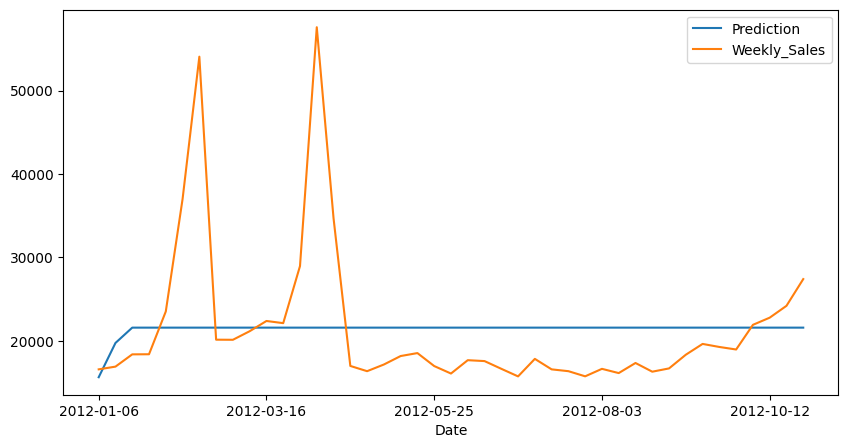

In [ ]:
#Grafico
pd.concat([Sarima_forecast_df,test[0][target]],axis=1).plot(figsize=(10, 5))

In [ ]:
#Prediccion del modelo Arima
#Se entrena con 10377 pasos hacia delante
Sarima_forecast = resultados_fit_Arima[1].predict(n_periods=len(test[1]))
Sarima_forecast_df = pd.DataFrame(Sarima_forecast.values,index = test[1].index,columns=['Prediction'])

<Axes: xlabel='Date'>

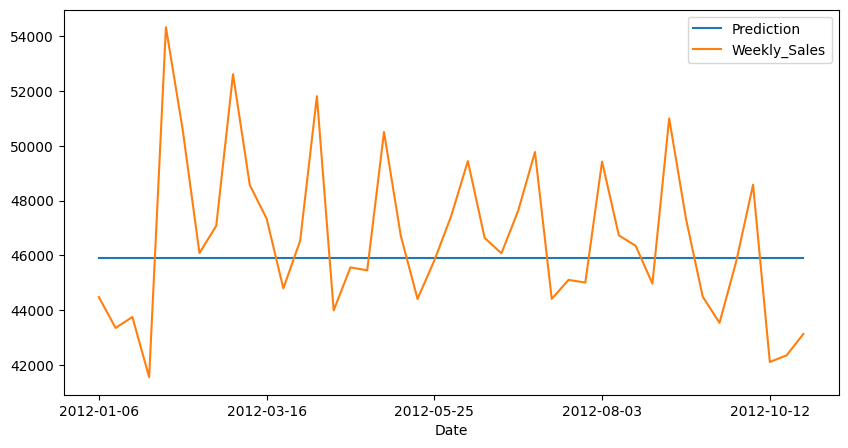

In [ ]:
#Grafico
pd.concat([Sarima_forecast_df,test[1][target]],axis=1).plot(figsize=(10, 5))

In [ ]:
#Se obtiene precision del modelo con metricas MAPE y RMSE
precision_mape_Arima=[]
precision_rmse_Arima=[]

i=0
while i<len(test_sample):
  result_mape = mape(test_sample[i]['Weekly_Sales'], resultados_predict_Arima[i])
  result_rmse = mse(test_sample[i]['Weekly_Sales'], resultados_predict_Arima[i],squared=False)
  precision_mape_Arima.append(result_mape)
  precision_rmse_Arima.append(result_rmse)
  i=i+1

In [ ]:
#De cada modelo entrendado se obtiene los coeficientes de p y q
p_q_arima=[]
for i in resultados_fit_Arima:
  x=i.get_params()
  aux_p=x['order'][0]
  aux_q=x['order'][2]
  p_q_arima.append([aux_p,aux_q])




In [ ]:
#De cada modelo entrendado se obtiene las metricas
precision_mape_Arima=np.array(precision_mape_Arima).reshape(-1,1)
precision_rmse_Arima=np.array(precision_rmse_Arima).reshape(-1,1)
p_q_arima=np.transpose(np.array(p_q_arima))

Se trabaja array para convertirlo en un archivo csv

In [ ]:
df_precision_mape_Arima=pd.DataFrame(precision_mape_Arima,columns=["Precision"])
df_precision_rmse_Arima=pd.DataFrame(precision_rmse_Arima,columns=["Precision"])
df_p_q_arima=pd.DataFrame(p_q_arima,columns=["p","q"])

In [ ]:
#CSV con los resultados
df_precision_mape_Arima.to_csv('df_precision_mape_Arima.csv')
df_precision_rmse_Arima.to_csv('df_precision_rmse_Arima.csv')
df_p_q_arima.to_csv('df_p_q_arima.csv')

#Sarima

Del modelo:
* Se entrena modelo Auto SArima para encontrar los mejores coeficientes del modelo.
* Se entrena con 43 pasos hacia delante
* Se obtiene precision del modelo con metricas MAPE y RMSE


In [ ]:
def Auto_Sarima(data,trace_value):
  SARIMA_model = pm.auto_arima(data,
                        test='adf',
                        max_p=6, max_q=6,
                        m=52,
                        d=None,
                        seasonal=True,
                        trace=trace_value,
                        error_action='warn',
                        suppress_warnings=True,
                        n_jobs=-1,
                        stepwise=True)
  return SARIMA_model

In [ ]:
#Muestra se serie
train_sample=train[0:5]
test_sample=test[0:5]

In [ ]:
#Entrenamiento del modelo Arima
resultados_fit_Sarima=[]
serie_analizada=[]
i=0
for serie in train_sample:
  Sarima_model=Auto_Sarima(serie['Weekly_Sales'],False)
  Sarima_model.fit(serie['Weekly_Sales'])
  resultados_fit_Sarima.append(Sarima_model)

In [ ]:
#Prediccion del modelo Arima
#Se entrena con 43 pasos hacia delante
n_periods=len(test[0])
resultados_predict_Sarima=[]
i=0
for serie in resultados_fit_Sarima:
  Sarima_predict=serie.predict(n_periods=n_periods)
  resultados_predict_Sarima.append(Sarima_predict)


In [ ]:
#Prediccion del modelo Arima
#Se entrena con 10377 pasos hacia delante
Sarima_forecast = resultados_fit_Sarima[0].predict(n_periods=len(test[0]))
Sarima_forecast_df = pd.DataFrame(Sarima_forecast.values,index = test[0].index,columns=['Prediction'])

<Axes: xlabel='Date'>

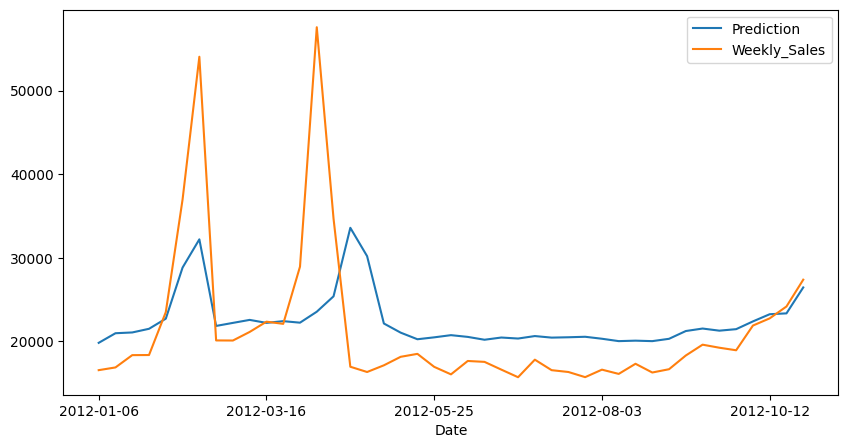

In [ ]:
#Grafico
pd.concat([Sarima_forecast_df,test[0][target]],axis=1).plot(figsize=(10, 5))

In [ ]:
#Prediccion del modelo Arima
#Se entrena con 10377 pasos hacia delante
Sarima_forecast = resultados_fit_Sarima[1].predict(n_periods=len(test[1]))
Sarima_forecast_df = pd.DataFrame(Sarima_forecast.values,index = test[1].index,columns=['Prediction'])

<Axes: xlabel='Date'>

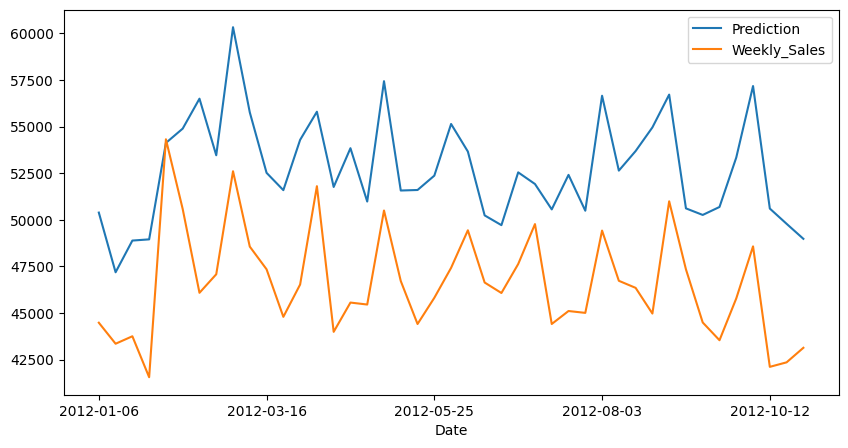

In [ ]:
#Grafico
pd.concat([Sarima_forecast_df,test[1][target]],axis=1).plot(figsize=(10, 5))

In [ ]:
#Se obtiene precision del modelo con metricas MAPE y RMSE
precision_mape_Sarima=[]
precision_rmse_Sarima=[]

i=0
while i<len(test_sample):
  result_mape = mape(test_sample[i]['Weekly_Sales'], resultados_predict_Sarima[i])
  result_rmse = mse(test_sample[i]['Weekly_Sales'], resultados_predict_Sarima[i],squared=False)
  precision_mape_Sarima.append(result_mape)
  precision_rmse_Sarima.append(result_rmse)
  i=i+1

In [ ]:
resultados_predict_Sarima

In [ ]:
#De cada modelo entrendado se obtiene los coeficientes de p y q
p_q_Sarima=[]
for i in resultados_predict_Sarima:
  x=i.get_params()
  aux_p=x['order'][0]
  aux_q=x['order'][2]
  p_q_Sarima.append([aux_p,aux_q])


In [ ]:
#De cada modelo entrendado se obtiene las metricas
precision_mape_Sarima=np.array(precision_mape_Sarima).reshape(-1,1)
precision_rmse_Sarima=np.array(precision_rmse_Sarima).reshape(-1,1)
p_q_Sarima=np.transpose(np.array(p_q_Sarima))


AttributeError: ignored

Se trabaja array para convertirlo en un archivo csv

In [ ]:
df_precision_mape_Sarima=pd.DataFrame(precision_mape_Sarima,columns=["Precision"])
df_precision_rmse_Sarima=pd.DataFrame(precision_rmse_Sarima,columns=["Precision"])
df_p_q_Sarima=pd.DataFrame(p_q_Sarima,columns=["p","q"])

In [ ]:
#CSV con los resultados
df_precision_mape_Sarima.to_csv('df_precision_mape_Arima.csv')
df_precision_rmse_Sarima.to_csv('df_precision_rmse_Arima.csv')
df_p_q_Sarima.to_csv('df_p_q_arima.csv')